Phase 2 — Prétraitement & Analyse exploratoire

In [3]:
# librairies necessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium



In [4]:
data = pd.read_csv('merged_data.csv')

data.head()

,Domain Code,Domain,Country,Element,Months,Year,Unit,Value,Flag,Flag Description,...,Subregion,Region,Magnitude,Magnitude Scale,Month,Total Deaths,No. Homeless,Total Affected,Total Damage ('000 US$),CPI
0,ET,Temperature change on land,Afghanistan,Temperature change,January,1963,°c,2.706,E,Estimated value,...,Southern Asia,Asia,92544.098768,Km2,4.0,107.0,NaN,788530.57451,NaN,10.05081
1,ET,Temperature change on land,Afghanistan,Temperature change,February,1963,°c,3.875,E,Estimated value,...,Southern Asia,Asia,92544.098768,Km2,4.0,107.0,NaN,788530.57451,NaN,10.05081
2,ET,Temperature change on land,Afghanistan,Temperature change,March,1963,°c,0.365,E,Estimated value,...,Southern Asia,Asia,92544.098768,Km2,4.0,107.0,NaN,788530.57451,NaN,10.05081
3,ET,Temperature change on land,Afghanistan,Temperature change,April,1963,°c,0.859,E,Estimated value,...,Southern Asia,Asia,92544.098768,Km2,4.0,107.0,NaN,788530.57451,NaN,10.05081
4,ET,Temperature change on land,Afghanistan,Temperature change,May,1963,°c,-0.727,E,Estimated value,...,Southern Asia,Asia,92544.098768,Km2,4.0,107.0,NaN,788530.57451,NaN,10.05081


In [ ]:
#Supression des colonnes inutiles
data.drop(['Month'], axis=1, inplace=True)

# Renommage des colonnes
data.rename(columns={'Value': 'Temperature'}, inplace=True)

# Suppression des doublons
data.drop_duplicates(inplace=True)

# Gestion des valeurs manquantes
data['Magnitude'] = data.groupby('Disaster Type')['Magnitude'].transform(lambda x: x.fillna(x.mean()))
data['Magnitude'].fillna(data['Magnitude'].mean(), inplace=True)

data.isnull().sum()


In [7]:
#data.isnull().sum()
print(data.columns)

Index(['Domain Code', 'Domain', 'Country', 'Element', 'Months', 'Year', 'Unit',
       'Temperature', 'Flag', 'Flag Description', 'DisNo.',
       'Classification Key', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'ISO', 'Subregion', 'Region',
       'Magnitude', 'Magnitude Scale', 'Total Deaths', 'No. Homeless',
       'Total Affected', 'Total Damage ('000 US$)', 'CPI'],
      dtype='object')


Calcul de moyennes mobiles et anomalies 

In [6]:
# A) Calcul de la moyenne mobile exponentielle sur 5 périodes
data['Temperature_moyen_mobile'] = data['Temperature'].ewm(span=5, adjust=False).mean()

print (data['Temperature_moyen_mobile'].head(5))

0    2.706000
1    3.095667
2    2.185444
3    1.743296
4    0.919864
Name: Temperature_moyen_mobile, dtype: float64


In [7]:
# B) Détection des anomalies
# Calcul de la moyenne et de l'écart-type
moyenne = data['Temperature'].mean()
ecart_type = data['Temperature'].std()

# Définition d'un seuil pour les anomalies (2 écarts-types)
seuil_anomalie = 2
data['anomalie'] = np.abs(data['Temperature'] - moyenne) > (seuil_anomalie * ecart_type)

print(data['anomalie'].value_counts())
#print(data['anomalie'].head(5))

anomalie
False    83987
True      4885
Name: count, dtype: int64


Calcul et visualisation d'indicateurs climatiques 

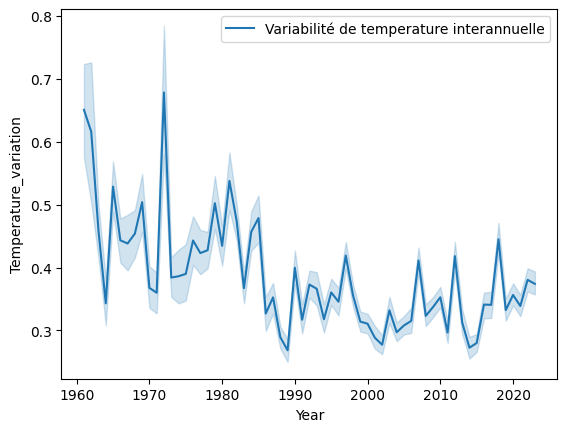

<Figure size 640x480 with 0 Axes>

In [10]:
# Calcul de la variabilité interannuelle avec un écart-type mobile 

# data = data[~data.index.duplicated(keep='first')]
# Écart-type mobile sur une fenêtre de 5 ans pour la température
data['Temperature_variation'] = data['Temperature'].rolling(window=5).std()

# Visualisation
sns.lineplot(data=data, x='Year', y='Temperature_variation', label='Variabilité de temperature interannuelle')
plt.legend()
plt.show()

#  Sauvegarde des images
plt.savefig('variabilite_interannuelle.png')

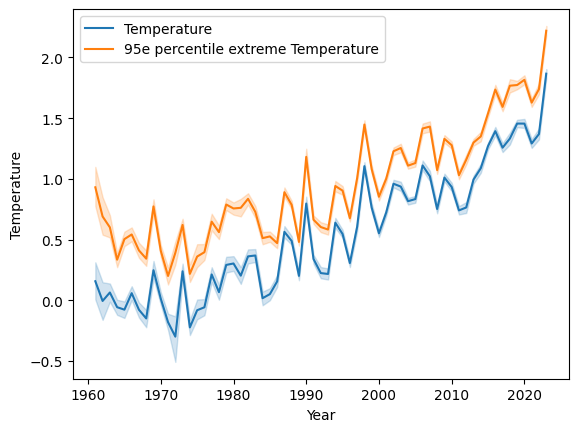

<Figure size 640x480 with 0 Axes>

In [11]:
# Calcul de l'indice de temperatures extrêmes avec une fenêtre glissante

# Calcul du 95e percentile sur une fenêtre glissante de 5 ans
data['Temperature_extreme'] = data['Temperature'].rolling(window=5).quantile(0.95)

#data['Temperature_extreme'].head(5)

# Visualisation
sns.lineplot(data=data, x='Year', y='Temperature', label='Temperature')
sns.lineplot(data=data, x='Year', y='Temperature_extreme', label='95e percentile extreme Temperature')
plt.legend()
plt.show()

#  Sauvegarde des images
plt.savefig('temperature_extreme.png')

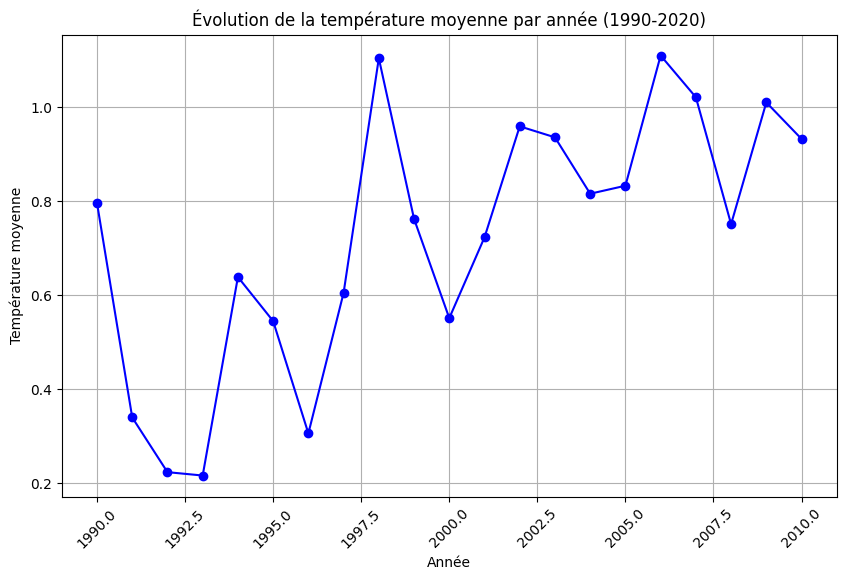

<Figure size 640x480 with 0 Axes>

In [12]:
# Température moyenne par année
mean_temp_per_year = data.groupby('Year')['Temperature'].mean()

# Filtre des données pour une plage d'années spécifique (par exemple, 1990 à 2020)
filtered_data = mean_temp_per_year.loc[1990:2010]

# Graphe de la température moyenne par année
plt.figure(figsize=(10, 6))
filtered_data.plot(kind='line', marker='o', color='b')
plt.title("Évolution de la température moyenne par année (1990-2020)")
plt.xlabel("Année")
plt.ylabel("Température moyenne")
plt.xticks(rotation=45) 
plt.grid()
plt.show()

#  Sauvegarde des images
plt.savefig('temperature_moyenne.png')

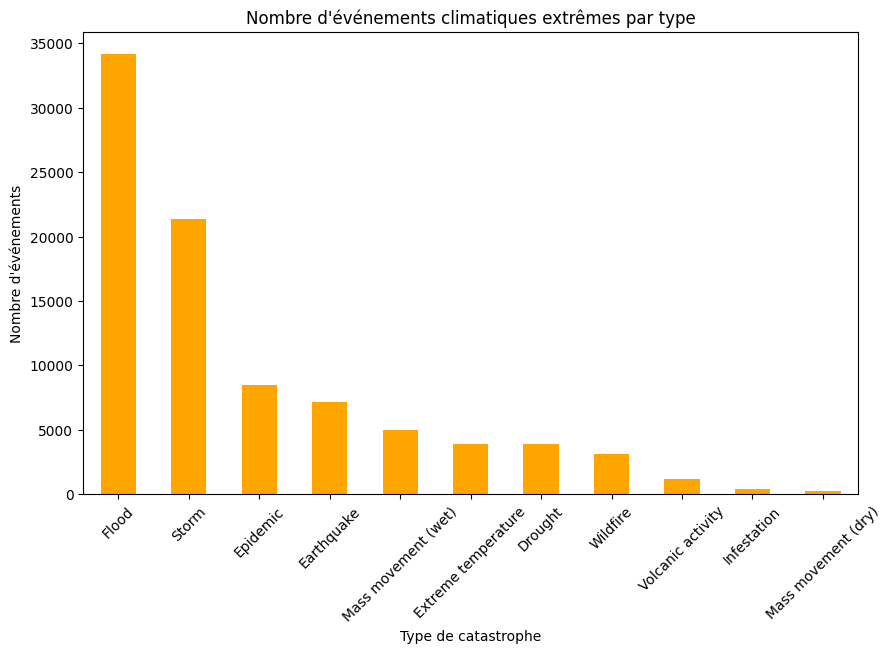

In [25]:
# Nombre d'événements climatiques  par type
extreme_events = data['Disaster Type'].value_counts()

# Histogramme des types de catastrophes naturelles
plt.figure(figsize=(10, 6))
extreme_events.plot(kind='bar', color='orange')
plt.title("Nombre d'événements climatiques extrêmes par type")
plt.xlabel("Type de catastrophe")
plt.ylabel("Nombre d'événements")
plt.xticks(rotation=45)
plt.show()


Phase 3 — Visualisation spatiale et géographique

Représentation des données de temperatures par continent

In [ ]:
import plotly.express as px

# Agrégation des données à l'échelle des continents
region_data = data.groupby('Region', as_index=False)['Temperature'].mean().reset_index()


fig_region = px.choropleth(
    region_data,
    locations="Region",
    locationmode="country names", 
    color="Temperature",
    hover_name="Region",
    color_continuous_scale="RdYlBu_r",
    title="Carte des températures moyennes par continent"
)
fig_region.show()

#  Sauvegarde de la carte
fig_region.write_html("temperature_region.html")


In [15]:

# Agrégation des températures par pays
data_temp = data.groupby(['ISO', 'Country'], as_index=False)['Temperature'].mean()

fig_temp = px.choropleth(
    data_temp,
    locations='ISO',                # Code ISO des pays
    color='Temperature',            # Variable pour la coloration
    hover_name='Country',           # Affichage lors du survol
    color_continuous_scale='RdYlBu_r',# Choix de la palette (RdYlBu avec inversion pour voir le chaud/froid)
    title='Température moyenne par pays'
)
fig_temp.show()

# Sauvegarde de la carte
fig_temp.write_html('carte_temperature.html')


In [ ]:

# Les pays ayant un nombre de catastrophes élevé

# Nombre de catastrophes par pays
data_disaster = data.groupby('ISO', as_index=False)['DisNo.'].count()
#data_disaster.rename(columns={'DisNo.': 'Nombre_désastres'}, inplace=True)

# Chargement des données géographiques mondiales
world = gpd.read_file(r"C:\Users\Hilary\Desktop\IR5_ANGLO_ESAIP\Majeure Big Data\Open Data\TP3\ne_110m_admin_0_countries.shp")

# Fusion avec le GeoDataFrame mondial
merged_disaster = world.merge(data_disaster, left_on='SOV_A3', right_on='ISO', how='left')

# Création de la carte
map_disaster = folium.Map(location=[20, 0], zoom_start=2)

# Ajout de la couche choroplèthe pour les catastrophes
folium.Choropleth(
    geo_data=merged_disaster,
    data=merged_disaster,
    columns=['SOV_A3', 'DisNo.'],
    key_on='feature.properties.SOV_A3',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Nombre de catastrophes naturelles'
).add_to(map_disaster)

# Sauvegarde de la carte
map_disaster.save('carte_disaster_monde.html')


Visualisation pour la france

In [ ]:
# Filtre des données pour la France
france_data = data[data['Country'] == 'France']
print(france_data.head())

# Température moyenne par année pour la France
france_temp_by_year = france_data.groupby('Year')['Temperature'].mean().reset_index()
print(france_temp_by_year)

# Nombre de désastres par année
france_disasters_by_year = france_data.groupby('Year')['DisNo.'].count().reset_index()
print(france_disasters_by_year)

In [18]:
# Fusion des données de température et de désastres
france_combined = pd.merge(france_temp_by_year, france_disasters_by_year, on='Year', how='inner')

# Trier les données par nombre de désastres en ordre décroissant
top_5_disasters = france_combined.sort_values(by='DisNo.', ascending=False).head(5)

# Afficher les 5 années avec le plus de désastres
print(top_5_disasters)

    Year  Temperature  DisNo.
47  2019     1.983765     170
18  1990     1.393059     170
49  2021     1.300529     153
51  2023     2.663765     136
11  1983     0.675765     136


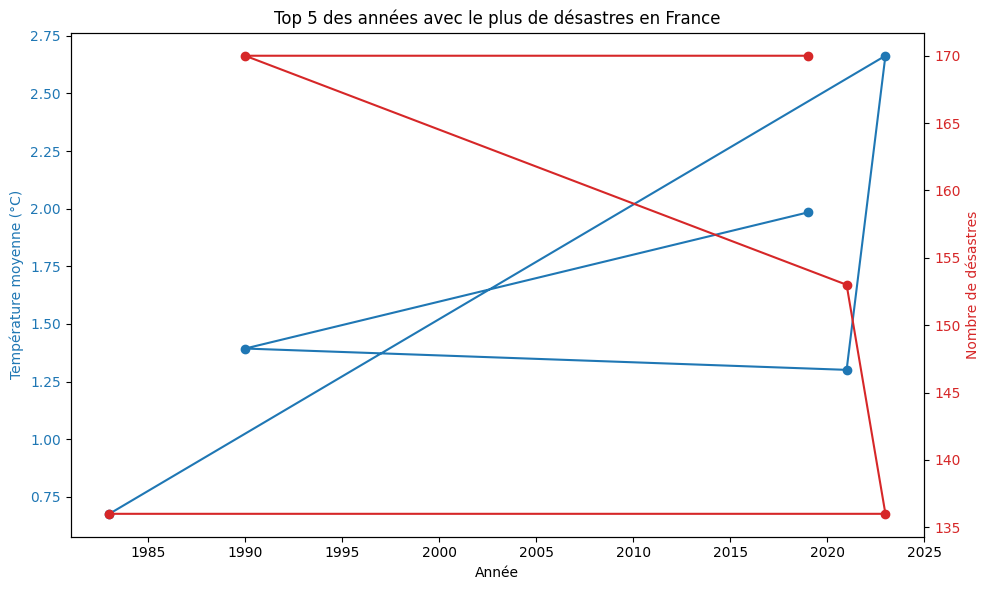

<Figure size 640x480 with 0 Axes>

In [26]:
# Création d'un graphique combiné pour les 10 années avec le plus de désastres
fig, ax1 = plt.subplots(figsize=(10, 6))

# Tracer la température moyenne
ax1.set_xlabel('Année')
ax1.set_ylabel('Température moyenne (°C)', color='tab:blue')
ax1.plot(top_5_disasters['Year'], top_5_disasters['Temperature'], label='Température moyenne', color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Ajouter une deuxième échelle pour le nombre de désastres
ax2 = ax1.twinx()
ax2.set_ylabel('Nombre de désastres', color='tab:red')
ax2.plot(top_5_disasters['Year'], top_5_disasters['DisNo.'], label='Nombre de désastres', color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titre et légende
plt.title("Top 5 des années avec le plus de désastres en France")
fig.tight_layout()
plt.show()

# Sauvegarde de l'image
plt.savefig('top_5_disasters_france.png')

Phase 4 — Analyse avancée et interprétation

Calcul d’anomalies climatiques (différences vs moyenne 1951–1980)

In [20]:
# Agrégation des températures moyennes et le nombre total de catastrophes par année
data_year = data.groupby('Year').agg({
    'Temperature': 'mean',
    'DisNo.': 'count'   
}).reset_index()

# Calcule de la température de référence (moyenne sur la période 1951-1980)
baseline = data_year[(data_year['Year'] >= 1951) & (data_year['Year'] <= 2010)]['Temperature'].mean()
print("Température moyenne de référence (1951-1999) :", baseline)

# Calcul de l'anomalie pour chaque année
data_year['Temp_anomaly'] = data_year['Temperature'] - baseline

# Afficher un aperçu des données agrégées avec anomalies
print(data_year.head())


Température moyenne de référence (1951-1999) : 0.36071374019643543
   Year  Temperature  DisNo.  Temp_anomaly
0  1961     0.156681     119     -0.204033
1  1962    -0.005824      85     -0.366537
2  1963     0.063903     238     -0.296810
3  1964    -0.057221     204     -0.417934
4  1965    -0.077499     391     -0.438212


 Tableau de corrélation entre climat et catastrophes naturelles

Tableau de corrélation :
              Temperature    DisNo.
Temperature     1.000000  0.829136
DisNo.          0.829136  1.000000


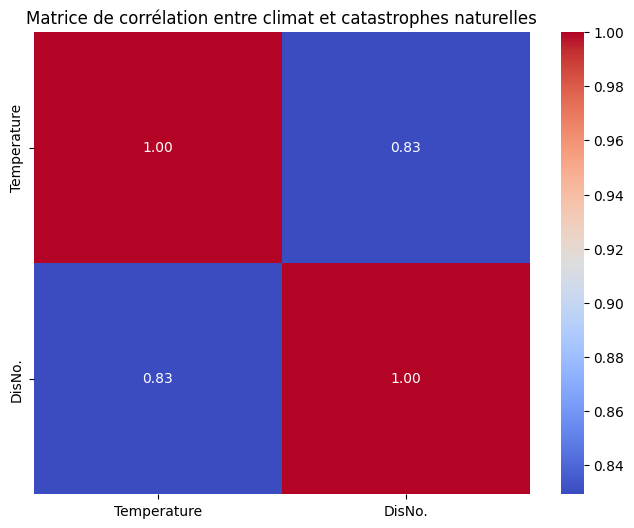

<Figure size 640x480 with 0 Axes>

In [21]:

# Sélection des colonnes d'intérêt
colonnes_corr = ['Temperature',  'DisNo.']

# Calcul de la matrice de corrélation
corr_matrix = data_year[colonnes_corr].corr()
print("Tableau de corrélation :\n", corr_matrix)

# Visualisation graphique avec une heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation entre climat et catastrophes naturelles")
plt.show()

# Sauvegarde de l'image     
plt.savefig('matrice_correlation.png')


 Modèle d’analyse avec hypothèses causales

 Régression multiple

In [22]:
import statsmodels.api as sm

# Définir la variable dépendante (nombre de catastrophes) et la variable indépendante (anomalie)
X = data_year[['Temp_anomaly']]
y = data_year['DisNo.']

# Ajout d'une constante pour le modèle (interception)
X = sm.add_constant(X)

# Ajustement du modèle OLS
model = sm.OLS(y, X).fit()

# Affichage du résumé du modèle
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 DisNo.   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     134.2
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           4.79e-17
Time:                        23:33:47   Log-Likelihood:                -482.06
No. Observations:                  63   AIC:                             968.1
Df Residuals:                      61   BIC:                             972.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1142.0811     69.198     16.505   

Test de causalité de Granger

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests

# Préparer un DataFrame avec les deux variables d'intérêt
data_granger = data_year[['Temp_anomaly', 'DisNo.']].dropna()

# Définir le nombre de retards à tester (par exemple 1 à 3 ans)
max_lag = 3

# Effectuer le test de causalité de Granger
print("Test de causalité de Granger (Temp_anomaly cause Nombre_désastres):")
granger_result1 = grangercausalitytests(data_granger[['DisNo.', 'Temp_anomaly']], max_lag, verbose=True)

print("Test de causalité de Granger (Nombre_désastres cause Temp_anomaly):")
granger_result2 = grangercausalitytests(data_granger[['Temp_anomaly', 'DisNo.']], max_lag, verbose=True)


Test de causalité de Granger (Temp_anomaly cause Nombre_désastres):

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1735  , p=0.1457  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.2840  , p=0.1307  , df=1
likelihood ratio test: chi2=2.2429  , p=0.1342  , df=1
parameter F test:         F=2.1735  , p=0.1457  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5138  , p=0.6010  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.1194  , p=0.5714  , df=2
likelihood ratio test: chi2=1.1093  , p=0.5743  , df=2
parameter F test:         F=0.5138  , p=0.6010  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9156  , p=0.4397  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=3.1095  , p=0.3750  , df=3
likelihood ratio test: chi2=3.0316  , p=0.3868  , df=3
parameter F test:         F=0.9156  , p=0.4397  , df_denom=53, df_num=3
Test de causalité de Granger (No

c:\Users\Hilary\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

c:\Users\Hilary\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results



Phase 5 — Propositions de solutions

 Simulation de scénarios de réchauffement

In [24]:
import statsmodels.api as sm

# Extraction des coefficients du modèle
coef_intercept = model.params['const']
coef_slope = model.params['Temp_anomaly']

# Créaction d'un DataFrame pour simuler nos scénarios
scenarios = [1.5, 2.0, 3.0]
scenario_data = pd.DataFrame({'Scenario (°C)': scenarios})

# Estimation du nombre de catastrophes attendues en appliquant le modèle
scenario_data['Predicted_Nombre_désastres'] = coef_intercept + coef_slope * scenario_data['Scenario (°C)']

print("Simulation des scénarios de réchauffement et leurs impacts estimés :")
print(scenario_data)


Simulation des scénarios de réchauffement et leurs impacts estimés :
   Scenario (°C)  Predicted_Nombre_désastres
0            1.5                 3332.399363
1            2.0                 4062.505450
2            3.0                 5522.717624


Proposition d'actions locales

Pour chacun de ces scénarios, quelques actions locales peuevnt être mises en œuvre :
- Mobilité douce : 
Développer les infrastructures pour les transports en commun, pistes cyclables et zones piétonnes afin de réduire les émissions liées au transport.
- Sobriété énergétique : 
Encourager la rénovation énergétique des bâtiments, promouvoir l'utilisation d'énergies renouvelables pour réduire l'empreinte carbone globale.
- Reforestation et protection des écosystèmes :
Planter des arbres et restaurer les espaces naturels pour agir comme puits de carbones.